In [1]:
from keras.models import load_model,Sequential
from keras.layers import Input, Dense, LSTM,Dropout
from keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint


import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics import confusion_matrix , accuracy_score

def signal_to_catagorical(data):
  data.loc[data['Signal'] == 'wait ot hold', 'Signal'] = 'wait or hold'
  data.loc[data['Signal'] == 'buy', 'Signal'] = 0
  data.loc[data['Signal'] == 'sell', 'Signal'] = 1 
  data.loc[data['Signal'] == 'wait or hold', 'Signal'] = 2 
  return data

def add_shift_day(data,day):
  r_list = []
  for i in range(day,len(data)):#Number mean day to shift
    r_list.append(data[i-day : i])
  return np.array(r_list)



In [2]:
def fillindicator(df):
    indicator = Indicator()
    train_set = indicator.MACD(df,12,26,9,1)#MACD 1
    train_set = indicator.MACD(df,40,60,34,2)#MACD 2
    train_set = indicator.DMI(df,14)
    train_set = indicator.STOCHRSI(df)
    train_set = indicator.AO(df)
    train_set = indicator.WILLIANSR(df)
    train_set = indicator.RSI(df)
    train_set = indicator.MA(df,26)
    train_set['MA-26'] = train_set['MA']
    train_set = indicator.MA(df,15)
    train_set = indicator.check_trend(df)
    return train_set

def shiftdata(df,col_name,sft):
    for i in range(sft):
        i+=1
        shiftname = col_name+'-'+str(i)
        df[shiftname] = df[col_name].shift(i)

    return df

def norm(df,col_name):# this will get columnname + _n
    #Normalize data each colunm in to range -1 to 1
    df[col_name+'_n'] = 2*(df[col_name]-df[col_name].min())/(df[col_name].max()-df[col_name].min())-1    
    return df

In [5]:
model = Sequential()
model.add(LSTM(100, input_shape=((30,6)),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

checkpoint = ModelCheckpoint('Model4_checkpoint.h5',
                               verbose=1,
                               monitor='val_acc',
                               mode='max',
                               save_best_only = True)



In [4]:
df = pd.read_csv('train.csv',index_col=False)
df

,Date,High,Low,Open,Close,Volume,Adj Close,Signal,MACD-1,SIGNAL LINE1,...,minusDI_n,DMI_n,%K_n,%D_n,STOCHRSI_n,Close_n,%R_n,RSI_n,AO_n,MA-trend_n
0,12/30/2002,13.061517,12.553648,12.911302,12.882689,2297300,11.157038,wait or hold,0.364033,0.387477,...,-0.203875,0.232065,0.377839,0.438333,-0.123190,-0.714058,0.415929,0.291105,0.488264,-0.284682
1,12/31/2002,13.011445,12.725322,12.839771,12.846924,1627900,11.126063,wait or hold,0.344716,0.378925,...,-0.233345,0.224723,0.184685,0.311759,-0.242551,-0.716054,0.354545,0.275891,0.466328,-0.280717
2,1/2/2003,13.726752,12.975679,13.032905,13.690988,3381000,11.857063,wait or hold,0.392594,0.381659,...,-0.317062,0.400249,0.374540,0.343575,0.039884,-0.668930,0.963236,0.513269,0.457600,-0.396510
3,1/3/2003,13.905580,13.462089,13.590844,13.626610,2622500,11.801311,wait or hold,0.420516,0.389430,...,-0.355279,0.429652,0.626184,0.485539,0.236292,-0.672524,0.737374,0.484522,0.453791,-0.389280
4,1/6/2003,14.384835,13.590844,13.590844,14.277539,5549500,12.365048,wait or hold,0.489263,0.409397,...,-0.418066,0.521124,0.953603,0.720533,0.402181,-0.636182,0.917583,0.633733,0.463165,-0.476581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199867,26/1/2015,22.400000,22.000000,22.100000,22.000000,14415800,18.193920,wait or hold,0.051086,0.071085,...,-0.101863,-0.244507,0.437368,0.367595,0.089435,0.831409,0.111112,-0.035124,-0.161851,0.105173
199868,27/1/2015,22.200001,21.900000,22.200001,22.100000,6106600,18.276617,wait or hold,0.053291,0.067526,...,-0.087141,-0.263767,0.434708,0.403530,0.019828,0.841399,0.222223,0.000931,-0.169310,0.059116
199869,28/1/2015,22.400000,22.000000,22.299999,22.100000,10041100,18.276617,wait or hold,0.054412,0.064903,...,-0.128891,-0.207052,0.432049,0.420163,-0.014976,0.841399,0.222223,0.000931,-0.154392,0.045734
199870,29/1/2015,22.100000,21.900000,22.000000,22.000000,6246500,18.193920,wait or hold,0.046693,0.061261,...,-0.101545,-0.230463,0.419538,0.422203,-0.041290,0.831409,0.111112,-0.041527,-0.141090,0.078408


In [7]:
df = signal_to_catagorical(df)
x_train = df[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','AO_n','RSI_n','MA-trend']].values
x_train = add_shift_day(x_train,30)
y_train = df['Signal'] 
y_train = to_categorical(y_train)
y_train = y_train.tolist()
del y_train[0:30]
y_train = np.array(y_train)

h = model.fit(x_train, y_train, epochs=50,shuffle=False)
# ,validation_data=(x_val,y_val),callbacks=[checkpoint]
model.save('Model5_2_100ep.h5')




Epoch 1/50
6246/6246 [==============================] - 288s 46ms/step - loss: 0.3020 - acc: 0.8737
Epoch 2/50
6246/6246 [==============================] - 295s 47ms/step - loss: 0.2947 - acc: 0.8770
Epoch 3/50
6246/6246 [==============================] - 266s 43ms/step - loss: 0.2930 - acc: 0.8779
Epoch 4/50
6246/6246 [==============================] - 267s 43ms/step - loss: 0.2861 - acc: 0.8818
Epoch 5/50
6246/6246 [==============================] - 264s 42ms/step - loss: 0.2800 - acc: 0.8843
Epoch 6/50
6246/6246 [==============================] - 264s 42ms/step - loss: 0.2748 - acc: 0.8867
Epoch 7/50
6246/6246 [==============================] - 258s 41ms/step - loss: 0.2697 - acc: 0.8899
Epoch 8/50
6246/6246 [==============================] - 249s 40ms/step - loss: 0.2653 - acc: 0.8910
Epoch 9/50
6246/6246 [==============================] - 238s 38ms/step - loss: 0.2607 - acc: 0.8939
Epoch 10/50
6246/6246 [==============================] - 244s 39ms/step - loss: 0.2585 - acc: 0.8937

In [6]:
model = load_model('Model5_1_50ep.h5')

In [9]:
datalist = [f for f in glob.glob("../../Dataset/*.csv")]
print('have stock = ',len(datalist))

have stock =  75


In [10]:
#validation 
val_list = []
for val_name in range(71,72):
    df = pd.read_csv(datalist[val_name])
    val_x = df
    # val_x = add_shift_day(val_x,30)
    val_list.append(val_x)

#test
test_list = []
for test_name in range(72,75):
    df = pd.read_csv(datalist[test_name])
    test = df
    # test = add_shift_day(test,30)
    test_list.append(test)

In [11]:
for test in test_list:
    # print(test)
    test = signal_to_catagorical(test)
    #   print(test)
    x_test = test[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','AO_n','RSI_n','MA-trend']].values
    x_test = add_shift_day(x_test,30)
    y_test = test['Signal'].values
    y_test = y_test.tolist()
    del y_test[0:30]
    y_test = np.array(y_test)

    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis = -1)
    y_test = y_test.astype('int64')
    cm = confusion_matrix(y_test, y_pred)
    ac = accuracy_score(y_test,y_pred)
    print("Confusion Matrix")
    print(cm)
    print("Accuracy")
    print(ac)

Confusion Matrix
[[ 338    0    9]
 [   0  234    2]
 [  40   43 1784]]
Accuracy
0.9616326530612245
Confusion Matrix
[[ 491    1   17]
 [   0  293   17]
 [  45   53 1690]]
Accuracy
0.9489835059455313
Confusion Matrix
[[ 463    0   18]
 [   3  398   14]
 [  34   47 1675]]
Accuracy
0.9562594268476622


Text(0.5, 0, 'Date')

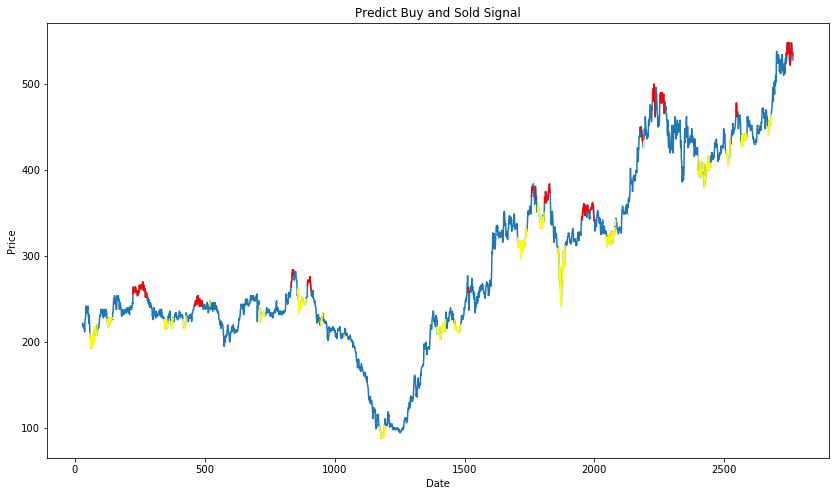

In [12]:
# p_test = test_list[1]
p_test = pd.read_csv(datalist[69])
p_test = signal_to_catagorical(p_test)
x_test = p_test[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','AO_n','RSI_n','MA-trend']].values
x_test = add_shift_day(x_test,30)
y_test = p_test['Signal'].values
y_test = y_test.tolist()
del y_test[0:30]
y_test = np.array(y_test)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis = -1)
p_test = p_test.iloc[30:]

p_test['pred'] = y_pred
p_test['pred_b'] = np.where(p_test['pred'] == 0,p_test['Close'],np.nan)
p_test['pred_s'] = np.where(p_test['pred'] == 1,p_test['Close'],np.nan)

plt.figure(figsize=(14,8))
# plt.grid()
plt.title('Predict Buy and Sold Signal')
plt.plot(p_test['Close'])
plt.plot(p_test['pred_b'],color='yellow')
plt.plot(p_test['pred_s'],color='red')
plt.ylabel('Price')
plt.xlabel('Date')

In [13]:
import pandas_datareader as web
import datetime
from Indicator import Indicator

start = datetime.datetime(2015,10,1)#26 day before start year for make indicator
end = datetime.datetime(2020,1,1)

In [14]:
stock = 'true.bk'
df = web.DataReader(stock,'yahoo',start,end)
df = fillindicator(df)
df['AO-signal'] = np.where(df['AO'] > df['AO'].shift(1),1,0)
df.loc[df['Trend'] == 'Down', 'Trend'] = 0.1
df.loc[df['Trend'] == 'Up', 'Trend'] = 0.9 

#Delta
df['MACD-SL-1'] = df['MACD-1'] - df['SIGNAL LINE1']
df['MACD-SL-2'] = df['MACD-2'] - df['SIGNAL LINE2']
df['DMI'] = df['plusDI'] - df['minusDI']
df['STOCHRSI'] = df['%K'] - df['%D']
df['MA-trend'] = df['MA-26'] - df['Close']

#MACD
df = norm(df,'MACD-SL-1')
df = norm(df,'MACD-SL-2')
df = norm(df,'MACD-1')
df = norm(df,'MACD-2')
df = norm(df,'SIGNAL LINE1')
df = norm(df,'SIGNAL LINE2')

#DMI
df = norm(df,'plusDI')
df = norm(df,'minusDI')
df = norm(df,'DMI')

#StochasticRSI
df = norm(df,'%K')
df = norm(df,'%D')
df = norm(df,'STOCHRSI')

#Other
df = norm(df,'Close')
df = norm(df,'%R')
df = norm(df,'RSI')
df = norm(df,'AO')
df = norm(df,'MA-trend')
df = df[63:]

C:\Users\jame_\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\jame_\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

Text(0.5, 0, 'Date')

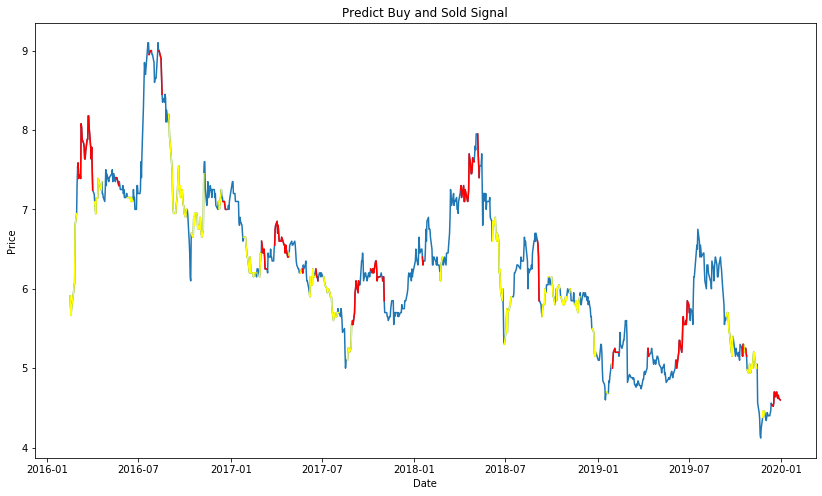

In [15]:
p_test = df
x_test = p_test[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','AO_n','RSI_n','MA-trend']].values
x_test = add_shift_day(x_test,30)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis = -1)
p_test = p_test.iloc[30:]

p_test['pred'] = y_pred
p_test['pred_b'] = np.where(p_test['pred'] == 0,p_test['Close'],np.nan)
p_test['pred_s'] = np.where(p_test['pred'] == 1,p_test['Close'],np.nan)

plt.figure(figsize=(14,8))
# plt.grid()
plt.title('Predict Buy and Sold Signal')
plt.plot(p_test['Close'])
plt.plot(p_test['pred_b'],color='yellow')
plt.plot(p_test['pred_s'],color='red')
plt.ylabel('Price')
plt.xlabel('Date')